In [33]:
#Import Libraries
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import ast
import seaborn as sns
from adjustText import adjust_text

#Load Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

#Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [34]:
job_title = 'Data Analyst'
job_place = 'United Kingdom'
df_da_uk = df[(df['job_title_short'] == job_title) & (df['job_country'] == job_place)].copy()
df_da_uk = df_da_uk.dropna(subset=['salary_year_avg'])
df_expl = df_da_uk.explode('job_skills')

In [35]:
df_da_skills = df_expl.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values('count', ascending=False)
df_da_skills = df_da_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'}) 
df_job_count = len(df_da_uk)
df_da_skills['skill_perc'] = df_da_skills['skill_count'] / df_job_count * 100
skill_lim = 6
df_da_skills_high_demand = df_da_skills[df_da_skills['skill_perc'] > skill_lim]
df_da_skills_high_demand


,skill_count,median_salary,skill_perc
job_skills,,,
sql,33,98500.0,45.833333
excel,29,75550.0,40.277778
python,25,89100.0,34.722222
tableau,13,100500.0,18.055556
r,9,77017.5,12.500000
go,9,71000.0,12.500000
sas,8,80007.0,11.111111
power bi,7,89100.0,9.722222
outlook,6,53857.0,8.333333


In [48]:
df_tech = df['job_type_skills'].copy()

df_tech = df_tech.drop_duplicates().dropna()

tech_dict = {}
for row in df_tech:
    row_dict = ast.literal_eval(row)
    for key, value in row_dict.items():
        if key in tech_dict:
            tech_dict[key] += value
        else:
            tech_dict[key] = value
for key, value in tech_dict.items():
    tech_dict[key] = list(set(value))


In [ ]:
df_tech = pd.DataFrame(list(tech_dict.items()), columns=['technology', 'skills'])
df_tech = df_tech.explode('skills')

In [56]:
df_plot = df_da_skills_high_demand.merge(df_tech, left_on='job_skills', right_on='skills')
df_plot

,skill_count,median_salary,skill_perc,technology,skills
0,33,98500.0,45.833333,programming,sql
1,29,75550.0,40.277778,analyst_tools,excel
2,25,89100.0,34.722222,programming,python
3,13,100500.0,18.055556,analyst_tools,tableau
4,9,77017.5,12.500000,programming,r
5,9,71000.0,12.500000,programming,go
6,8,80007.0,11.111111,analyst_tools,sas
7,8,80007.0,11.111111,programming,sas
8,7,89100.0,9.722222,analyst_tools,power bi
9,6,53857.0,8.333333,analyst_tools,outlook


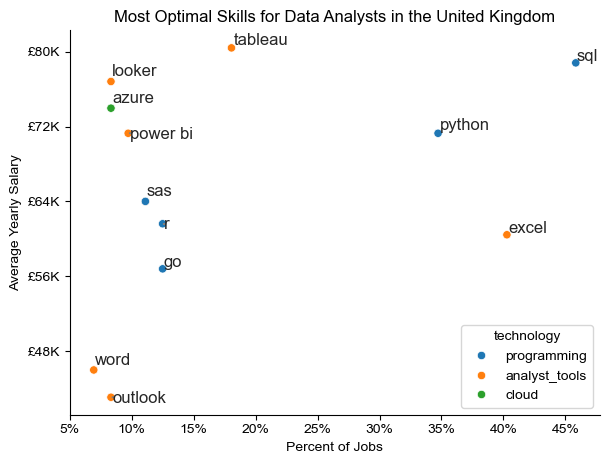

In [61]:
sns.scatterplot(data=df_plot, x='skill_perc', y='median_salary', hue='technology')
sns.set_theme(style='ticks')
sns.despine()
plt.title(f'Most Optimal Skills for {job_title}s in the {job_place}')
plt.xlabel('Percent of Jobs')
plt.ylabel('Average Yearly Salary')
plt.tight_layout()
texts = []
for i , txt in enumerate(df_da_skills_high_demand.index):
    texts.append(plt.text(df_da_skills_high_demand['skill_perc'].iloc[i], df_da_skills_high_demand['median_salary'].iloc[i], txt))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey', lw=1))
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'£{int((y*0.8)/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.show()